# Timelag Pipeline
Dask workflow for computing timelag maps from derotated and "prepped" level 1.5 data from the Atmospheric Imaging Assembly (AIA) instrument on the Solar Dynamics Observatory (SDO) spacecraft

In [1]:
import os
import sys
import glob
import datetime

import numpy as np
from scipy.interpolate import interp1d
from scipy.ndimage.interpolation import shift
import matplotlib.pyplot as plt
import dask
import dask.array as da
import distributed
from dask_kubernetes import KubeCluster
import gcsfs
from astropy.time import Time
import astropy.io
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.io.fits.hdu.base import BITPIX2DTYPE
import sunpy
from sunpy.map import Map
from sunpy.instr.aia import aiaprep
from sunpy.physics.differential_rotation import diffrot_map,solar_rotate_coordinate
from sunpy.util.metadata import MetaDict
import matplotlib.colors

#from timelag_analysis import DistributedAIACube,DistributedAIACollection,AIATimelags,get_header

%matplotlib inline

In [2]:
sunpy.version.version

'1.0.0.dev10022'

In [3]:
gcs = gcsfs.GCSFileSystem()
sorted(gcs.ls('pangeo-data/SDO_AIA_Images/diffrot/'))

['pangeo-data/SDO_AIA_Images/diffrot/094/',
 'pangeo-data/SDO_AIA_Images/diffrot/131/',
 'pangeo-data/SDO_AIA_Images/diffrot/171/',
 'pangeo-data/SDO_AIA_Images/diffrot/193/',
 'pangeo-data/SDO_AIA_Images/diffrot/211/',
 'pangeo-data/SDO_AIA_Images/diffrot/335/']

In [4]:
from dask_kubernetes import KubeCluster
cluster = KubeCluster(n_workers=100)
cluster

In [5]:
cluster.dashboard_link

'/user/wtbarnes/proxy/8787/status'

In [6]:
client = distributed.Client(cluster)

In [7]:
SAVE_DIR = 'gcs://pangeo-data/SDO_AIA_Images/diffrot/'

## The Data

The data we will be working with are a series of level 1.5 images from the 6 EUV channels, 94, 131, 171, 193, 211, and 335 Å, of AIA. These images have already been scaled to a common resolution ("prepped") and "derotated" to account for the rotation of the Sun about its axis as observed from SDO. Note that we could include the prep and derotate operations in our pipeline as well, but this would significantly increase the compute time.

First, let's define a data structure for stacking multiple FITS files to create an AIA data cube. This cube will be "lazily" evaluated such that the data will not be immediately loaded into memory. We'll call this object `DistributedAIACube`

In [8]:
def validate_dtype_shape(head):
    naxes = head['NAXIS']
    dtype = BITPIX2DTYPE[head['BITPIX']]
    shape = [head[f'NAXIS{n}'] for n in range(naxes, 0, -1)]
    return dtype, shape


def get_header(fn, hdu=0):
    with fn as fi:
        return MetaDict(sunpy.io.fits.get_header(fi)[hdu])


class DelayedFITS:
    def __init__(self, file, shape, dtype, hdu=0, verify=False):
        self.shape = shape
        self.dtype = dtype
        self.file = file
        self.hdu = hdu
        self.verify = verify

    def __getitem__(self, item):
        with self.file as fi:
            with astropy.io.fits.open(fi, memmap=True) as hdul:
                if self.verify:
                    hdul.verify('silentfix+warn')
                return hdul[self.hdu].data[item]


class DistributedAIACube(object):

    def __init__(self, maps):
        if not all([m.data.shape == maps[0].data.shape for m in maps]):
            raise ValueError('All maps must have same dimensions')
        if not all([m.data.dtype == maps[0].data.dtype for m in maps]):
            raise ValueError('All maps must have same dtype')
        self.maps = maps
        self.time = self._get_time()

    @classmethod
    def from_files(cls, fits_files, **kwargs):
        openfiles = dask.bytes.open_files(fits_files)
        headers = cls._get_headers(openfiles, **kwargs)
        dtype, shape = cls._get_dtype_and_shape(headers)
        maps = cls._get_maps(openfiles, headers, dtype, shape, **kwargs)
        return cls(maps)

    @staticmethod
    def _get_maps(openfiles, headers, dtype, shape, **kwargs):
        hdu = kwargs.get('hdu', 0)
        verify = kwargs.get('verify', False)
        arrays = [da.from_array(DelayedFITS(f, shape, dtype, hdu=hdu, verify=verify), chunks=shape)
                  for f in openfiles]
        return [Map(a, h) for a, h in zip(arrays, headers)]

    @staticmethod
    def _get_headers(openfiles, **kwargs):
        client = distributed.get_client()
        futures = client.map(get_header, openfiles, hdu=kwargs.get('hdu', 0))
        return client.gather(futures)

    @staticmethod
    def _get_dtype_and_shape(headers):
        dtypes = [validate_dtype_shape(h) for h in headers]
        if not all([d == dtypes[0] for d in dtypes]):
            raise ValueError('All maps must have same shape and dtype')
        return dtypes[0]

    def _get_time(self,):
        return u.Quantity([(Time(m.meta['t_obs']) - Time(self.maps[0].meta['t_obs'])).to(u.s) 
                            for m in self.maps])

    @property
    def shape(self,):
        return self.time.shape + self.maps[0].data.shape

    @property
    def dtype(self,):
        return self.maps[0].data.dtype

    @property
    def unstacked_data(self,):
        return [m.data for m in self.maps]

    @property
    def stacked_data(self,):
        return da.stack(self.unstacked_data)

    def rechunk(self, shape):
        return self.stacked_data.rechunk(shape)

    def average(self, **kwargs):
        chunks = kwargs.get('chunks', (self.shape[0], self.shape[1]//10, self.shape[2]//10))
        cube = self.rechunk(chunks)
        return sunpy.map.Map(cube.mean(axis=0, dtype=np.float64), self.maps[0].meta.copy())

    def submap(self, *args, **kwargs):
        return DistributedAIACube([m.submap(*args, **kwargs) for m in self.maps])

Let's first gather the data into 6 separate datacubes using Dask.

In [9]:
channels = [94,131,171,193,211,335]

In [10]:
cubes = [DistributedAIACube.from_files(os.path.join(SAVE_DIR, f'{c:03d}/*.fits' ))
         for c in channels]

Let's take a look at one of the maps. Note that the map is only brought into memory as needed.

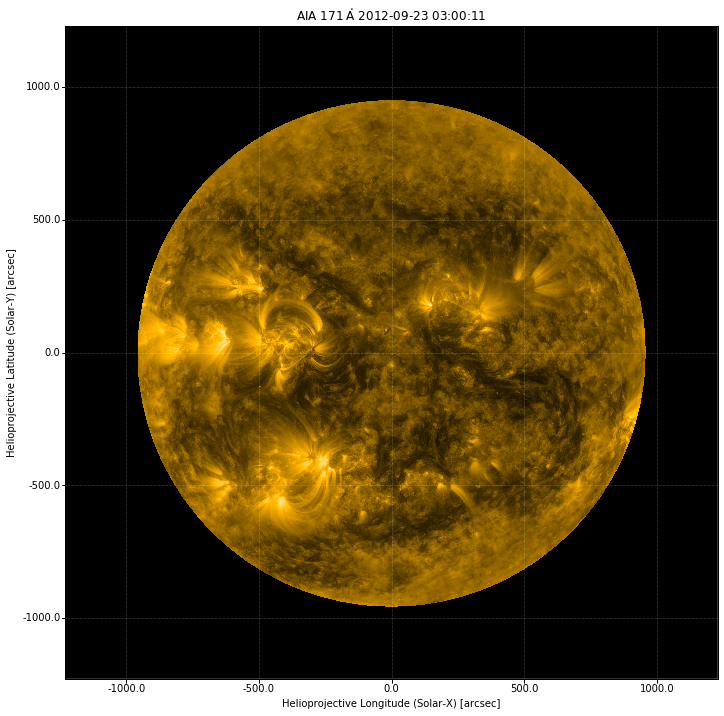

In [12]:
plt.figure(figsize=(12,12))
cubes[2].maps[0].plot()

## Cropping to the Active Region

We'll also identify the active region (AR) we are interested in and add the submap operation (i.e. cropping) to our pipeline. Note that we can crop each map in the same place as we have already removed the effect of the rotation of the Sun.

In [22]:
m = cubes[2].maps[0]
blc = SkyCoord(-600*u.arcsec,-700*u.arcsec,frame=m.coordinate_frame)
trc = SkyCoord(-100*u.arcsec,-200*u.arcsec,frame=m.coordinate_frame)

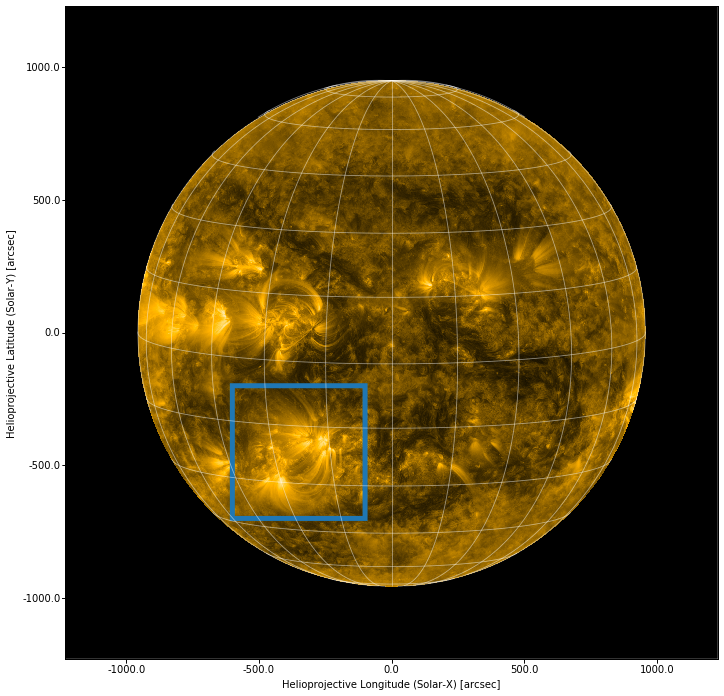

In [25]:
fig = plt.figure(figsize=(12,12))
ax = fig.gca(projection=m)
m.plot(axes=ax,title=False,)
m.draw_rectangle(blc,(trc.Tx - blc.Tx), (trc.Ty - blc.Ty), color='C0', lw=5)
ax.grid(alpha=0)
m.draw_grid(axes=ax,)

In [26]:
cubes = [c.submap(blc,trc) for c in cubes]

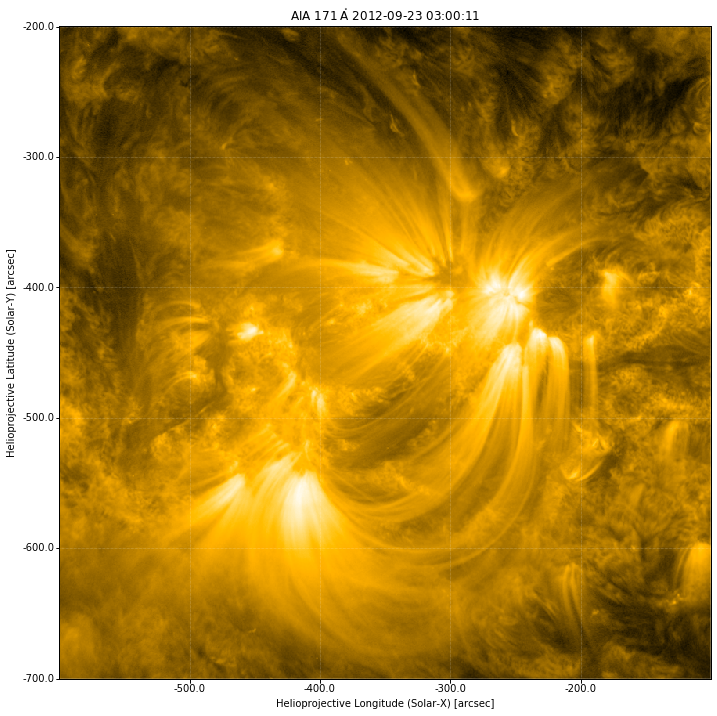

In [28]:
plt.figure(figsize=(12,12))
cubes[2].maps[0].plot()

## Timelags

The **timelag**, or the delay which maximizes the cross-correlation between two timeseries, is a useful quantity for understanding the thermal evolution of the coronal plasma between the passbands of the AIA instrument.

In temperature space, the EUV passbands on AIA have the following structure.

![](http://iopscience.iop.org/0004-637X/753/1/35/downloadFigure/figure/apj431449f1)

These are the so-called "temperature response functions" and they show approximately what temperatures each channel or passband is sensitive too.

As a blob of coronal plasma cools from 10 MK down to below 1 MK, we expect to see intensity peaks in consecutively cooler channels. If we then compute the cross-correlate of the intensity timeseries in two different channels as a function of the temporal offset between those two timeseries, the offset which maximizes the cross-correlation is the **timelag**. The timelag can then be used as a proxy for the plasma cooling time between two passbands.

This method was first applied to AIA data by [Viall and Klimchuk (2012)](http://iopscience.iop.org/article/10.1088/0004-637X/753/1/35/meta). They computed the timelag in every pixel of AR NOAA 11082 as observed by AIA. In doing so, they revealed large-scale cooing patterns across the entire active region. One of their results is shown below. Note the loop structures that are revealed by this method. This is a very powerful diagnostic for understanding the dynamics of coronal loop structures.

![](http://iopscience.iop.org/0004-637X/753/1/35/downloadFigure/figure/apj431449f5a)

Mathematically, we can express the timelag in terms of a Fourier transform, making it very simple to compute with Dask. We can express the cross-correlation $\mathcal{C}$ between two channels $A$ and $B$ as,

$$
    \mathcal{C}_{AB}(\tau) = \mathcal{I}_A(t)\star\mathcal{I}_B(t) = \mathcal{I}_A(-t)\ast\mathcal{I}_B(t)
$$

where $\star$ and $\ast$ represent the correlation and convolution operators, respectively, $\tau$ is the lag and

$$
    \mathcal{I}_c(t)=\frac{I_c(t)-\bar{I}_c}{\sigma_{c}},
$$

is the mean-subtracted and scaled intensity of channel $c$ as a function of time. Taking the fourier transform of both sides of the first equation and using the convolution theorem,

$$
\begin{align}
    \mathcal{F}\{\mathcal{C}_{AB}(\tau)\} &= \mathcal{F}\{\mathcal{I}_A(-t)\ast\mathcal{I}_B(t)\},\\
    &= \mathcal{F}\{\mathcal{I}_A(-t)\}\mathcal{F}\{\mathcal{I}_B(t)\}.
\end{align}
$$

Taking the inverse Fourier transform, $\mathcal{F}^{-1}$, of both sides of the above expression gives,

$$
    \mathcal{C}_{AB}(\tau) = \mathcal{F}^{-1}\{\mathcal{F}\{\mathcal{I}_A(-t)\}\mathcal{F}\{\mathcal{I}_B(t)\}\}.
$$

Scaling $\mathcal{C}_{AB}$ by the length of the intensity timeseries $I(t)$ yields the same result as that of the correlation defined in section 2 of [Viall and Klimchuk (2012)](http://iopscience.iop.org/article/10.1088/0004-637X/753/1/35/meta). Furthermore, the **timelag** between channels $A$ and $B$ is defined as,
$$
    \tau_{AB} = \mathrm{argmax}_{\tau}\,\mathcal{C}_{AB}(\tau).
$$

Now, we'll create a data structure to hold cubes for all EUV wavelengths and can compute the timelag in each pixel of our observation and return the resulting timelag to a single `Map` object for each pair of AIA EUV channels.

In [30]:
class AIATimelags(object):
    def __init__(self, *args, **kwargs):
        if not all([a.shape[1:] == args[0].shape[1:] for a in args]):
            raise ValueError('All spatial dimensions must be the same')
        if not all([a.shape[0] == args[0].shape[0] for a in args]):
            warnings.warn('Time dimensions are not all equal length')
        self._cubes = {a.maps[0].meta['wavelnth']: a for a in args}
        self.channels = sorted(list(self._cubes.keys()), key=lambda x: x)

    def __getitem__(self, channel):
        # Index
        if type(channel) is int and channel not in self.channels:
            channel = self.channels[channel]
        # Convert from string
        if type(channel) is str:
            channel = float(channel)
        return self._cubes[channel]
    
    @property
    def needs_interpolation(self,):
        if not all([c.shape[0] == self[0].shape[0] for c in self]):
            return True
        return ~np.all([u.allclose(c.time, self[0].time) for c in self])

    @property
    def timelags(self):
        time = self._interpolate_time if self.needs_interpolation else self[0].time
        delta_t = np.diff(time.value).cumsum()
        return np.hstack([-delta_t[::-1], np.array([0]), delta_t]) * time.unit
    
    @property
    def _interpolate_time(self,):
        min_t = min([c.time.min() for c in self])
        max_t = max([c.time.max() for c in self])
        n_t = max([c.time.shape[0] for c in self])
        return np.linspace(min_t, max_t, n_t)
    
    def _interpolate(self, time, cube):
        t_interp = self._interpolate_time
        def interp_wrapper(y):
            return interp1d(time, y, axis=0, kind='linear', fill_value='extrapolate')(t_interp)
        return da.map_blocks(interp_wrapper, cube, chunks=t_interp.shape+cube.chunks[1:],
                             dtype=cube.dtype)

    def correlation_2d(self, channel_a, channel_b, **kwargs):
        """
        Lazily compute cross-correlation in each pixel of an AIA map
        """
        # Shape must be the same in spatial direction
        chunks = kwargs.get('chunks', (self[channel_a].shape[1]//10,
                                       self[channel_a].shape[2]//10))
        cube_a = self[channel_a].rechunk(self[channel_a].shape[:1]+chunks)
        cube_b = self[channel_b].rechunk(self[channel_b].shape[:1]+chunks)
        if self.needs_interpolation:
            cube_a = self._interpolate(self[channel_a].time, cube_a)
            cube_b = self._interpolate(self[channel_b].time, cube_b)
        # Reverse the first timeseries
        cube_a = cube_a[::-1, :, :]
        # Normalize by mean and standard deviation
        std_a = cube_a.std(axis=0)
        std_a = da.where(std_a == 0, 1, std_a)
        v_a = (cube_a - cube_a.mean(axis=0)[np.newaxis, :, :]) / std_a[np.newaxis, :, :]
        std_b = cube_b.std(axis=0)
        std_b = da.where(std_b == 0, 1, std_b)
        v_b = (cube_b - cube_b.mean(axis=0)[np.newaxis, :, :]) / std_b[np.newaxis, :, :]
        # FFT of both channels
        fft_a = da.fft.rfft(v_a, axis=0, n=self.timelags.shape[0])
        fft_b = da.fft.rfft(v_b, axis=0, n=self.timelags.shape[0])
        # Inverse of product of FFTS to get cross-correlation (by convolution theorem)
        cc = da.fft.irfft(fft_a * fft_b, axis=0, n=self.timelags.shape[0])
        # Normalize by the length of the timeseries
        return cc / cube_a.shape[0]

    def make_correlation_map(self, channel_a, channel_b, **kwargs):
        cc = self.correlation_2d(channel_a, channel_b, **kwargs)
        bounds = kwargs.get('timelag_bounds', None)
        if bounds is not None:
            indices, = np.where(np.logical_and(self.timelags >= bounds[0],
                                               self.timelags <= bounds[1]))
            start = indices[0]
            stop = indices[-1] + 1
        else:
            start = 0
            stop = self.timelags.shape[0] + 1
        max_cc = cc[start:stop, :, :].max(axis=0).compute()
        meta = self[channel_a].maps[0].meta.copy()
        del meta['instrume']
        del meta['t_obs']
        del meta['wavelnth']
        meta['bunit'] = ''
        meta['comment'] = f'{channel_a}-{channel_b} cross-correlation'
        plot_settings = {'cmap': 'plasma'}
        plot_settings.update(kwargs.get('plot_settings', {}))
        correlation_map = sunpy.map.GenericMap(max_cc, meta, plot_settings=plot_settings)

        return correlation_map

    def make_timelag_map(self, channel_a, channel_b, **kwargs):
        cc = self.correlation_2d(channel_a, channel_b, **kwargs)
        bounds = kwargs.get('timelag_bounds', None)
        if bounds is not None:
            indices, = np.where(np.logical_and(self.timelags >= bounds[0],
                                               self.timelags <= bounds[1]))
            start = indices[0]
            stop = indices[-1] + 1
        else:
            start = 0
            stop = self.timelags.shape[0] + 1
        i_max_cc = cc[start:stop, :, :].argmax(axis=0).compute()
        max_timelag = self.timelags[start:stop][i_max_cc]
        meta = self[channel_a].maps[0].meta.copy()
        del meta['instrume']
        del meta['t_obs']
        del meta['wavelnth']
        meta['bunit'] = 's'
        meta['comment'] = f'{channel_a}-{channel_b} timelag'
        plot_settings = {'cmap': 'RdBu_r', 'vmin': self.timelags[start:stop].value.min(),
                         'vmax': self.timelags[start:stop].value.max()}
        plot_settings.update(kwargs.get('plot_settings', {}))
        timelag_map = sunpy.map.GenericMap(max_timelag, meta.copy(),
                                           plot_settings=plot_settings.copy())
        return timelag_map

Now, let's create our timelag object

In [32]:
timelags = AIATimelags(*cubes)

## Compute and Visualize

Finally, let's compute a timelag in every pixel of the AR! Because the computation in each pixel is independent, we can distribute the spatial dimensions across multiple cores.

Let's first compute the timelag map for the 335-171 Å channel pair.

In [35]:
tl_335_171 = timelags.make_timelag_map(335,171,timelag_bounds=(-3*u.hour,3*u.hour))

And now, we can plot our map in the usual way.

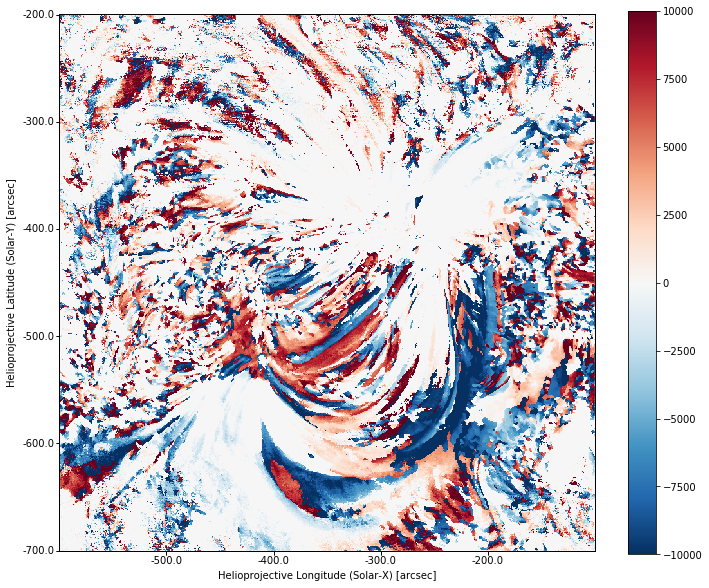

In [43]:
fig = plt.figure(figsize=(12,10))
ax = fig.gca(projection=tl_335_171)
im = tl_335_171.plot(axes=ax,vmin=-1e4,vmax=1e4,cmap='RdBu_r',title=False)
ax.grid(alpha=0)
fig.colorbar(im)

We can also compute the maximum value of the cross-correlation in each pixel to understand how correlated the two timeseries were.

In [44]:
cc_335_171 = timelags.make_correlation_map(335,171,timelag_bounds=(-3*u.hour,3*u.hour))

And now, we can plot our map in the usual way.

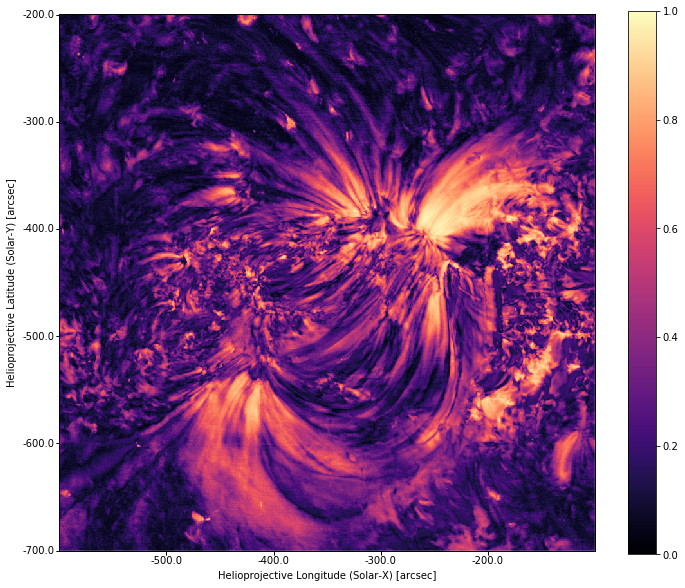

In [45]:
fig = plt.figure(figsize=(12,10))
ax = fig.gca(projection=cc_335_171)
im = cc_335_171.plot(axes=ax,vmin=0,vmax=1,cmap='magma',title=False)
ax.grid(alpha=0)
fig.colorbar(im)

## Aside: Functions for Computing Level 1.5 Data

In [10]:
ref_map = Map(os.path.join(SAVE_DIR,))

In [11]:
reference_observer = ref_map.observer_coordinate
reference_date = ref_map.date
reference_center = ref_map.center

In [12]:
@dask.delayed
def derotate(aia_map):
    new_coord = solar_rotate_coordinate(
        aia_map.center,
        reference_date,
        new_observer_location=reference_observer,
        rot_type='snodgrass')
    xs_pixel = (new_coord.Tx - reference_center.Tx)/aia_map.scale.axis1
    ys_pixel = (new_coord.Ty - reference_center.Ty)/aia_map.scale.axis2
    shifted_data = shift(aia_map.data, [ys_pixel.value, xs_pixel.value])
    derotated_map = Map(shifted_data, aia_map.meta)
    return derotated_map

In [13]:
@dask.delayed
def save_fits(aia_map):
    fn = os.path.join(SAVE_DIR, 'lev1.5', '{detector}_lev1.5_{date}_{channel}.fits'.format(
            detector=aia_map.meta['detector'].lower(), 
            date=aia_map.date.strftime('%Y%m%dT%H%M%S'),
            channel=aia_map.meta['wavelnth']))
    aia_map.save(fn)
    return fn

In [14]:
def build_level15_graph(cube):
    m_prep = [dask.delayed(aiaprep)(m) for m in cube.maps]
    m_derot = [derotate(m) for m in m_prep]
    return [save_fits(m) for m in m_derot]